# DBTL2: ART recommendations IN PROGRESS

This notebook demonstrates how ART can be used to model data from DBTL0 (single gRNA) and DBTL1 (double and triple gRNA) and make recommendations for new combiations of gRNA to increase isoprenol titer. 

This is part of the CRISPRi isoprenol project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl and refactored ART.

## Input and output

TODO: Update this


Required files to run this notebook:

- Either: 
    - Isoprenol DBTL1 and DBTL0 files from experimental data depot OR
    - Local files containing DBTL1 and DBTL0 isoprenol titers
    
Outputs generated by running this notebook:
- Folder ``dbtl1_art_outputs`` 
    - Trained art model `art.cpkl`
    - predictions vs measurement plots for cross-validated and non-cross-validated model
    - cross-validated and non-cross-validated performance metrics.

- Folder ``dbtl1_figures_and_analysis.csv``
    - Figures from data analysis
    - `DBTL1_rec_df.pkl` A pickled dataframe containing all possible recommendations evaluated by ART for their predicted posterior mean and standard deviation


## 1. Setup

### 1.1 Imports
Data preprocessing imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

ART imports

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../'
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
import warning_utils
warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 1.2 User parameters

In [3]:
user_params = {
    'output_dir'  : './dbtl3_figures_and_analysis/',
    'max_guide_rnas': 4
}



### 1.3a Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [4]:
# study_slug_dbtl0 = 'crispri-automation-for-isoprenol-production-in-p-p'
# study_slug_dbtl1 = 'crispri-automation-for-enhanced-isoprenol-producti'
# edd_server   = 'edd.jbei.org'
# username     = 'pckinnunen'

# try:
#     session = eddu.login(edd_server=edd_server, user=username)
# except:
#     print('ERROR! Connection to EDD failed. We will try to load data from disk...')
# else:
#     print('OK! Connection to EDD successful. We will try to load data from EDD...')
    
    
    
# try:
#     df_dbtl0 = eddu.export_study(session, study_slug_dbtl0, edd_server=edd_server)
# except (NameError, AttributeError, KeyError):
#     print(f'ERROR! Not able to export DBTL0 study.')
    
# try:
#     df_dbtl1 = eddu.export_study(session, study_slug_dbtl1, edd_server = edd_server)
# except (NameError, AttributeError, KeyError):
#     print(f'ERROR! Not able to export DBTL1 study.')   

### 1.3b Get isoprenol data locally
I used the script `pull_edd_isoprenol.ipynb` to previously download the data from EDD and filter it to only contain isoprenol.

In [5]:
df_dbtl0 = pd.read_pickle('./isoprenol_data/dbtl0_isoprenol.pkl')
df_dbtl1 = pd.read_pickle('./isoprenol_data/dbtl1_isoprenol.pkl')
df_dbtl2 = pd.read_pickle('./isoprenol_data/dbtl2_isoprenol.pkl')
df_dbtl3 = pd.read_pickle('./isoprenol_data/dbtl3_isoprenol.pkl')

The only protocol left in the data is GC-FID, corresponding to isoprenol measurements.

In [6]:
df_dbtl0['Protocol'].unique()

array(['GC-FID'], dtype=object)

In [7]:
df_dbtl1['Protocol'].unique()

array(['GC-FID'], dtype=object)

In [8]:
df_dbtl2['Protocol'].unique()

array(['GC-FID'], dtype=object)

In [9]:
df_dbtl3['Protocol'].unique()

array(['GC-FID'], dtype=object)

## 2. Data preprocessing

Compare the formats between datasets

In [10]:
df_dbtl0.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
594519,187352,CORRECTED: CRISPRi automation for enhanced iso...,187360,3475b66f-023e-4334-a86d-374b4094f346,Control-R1,BL1A1_NT,GC-FID,188815,Control-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,177.33700,24.0
594520,187352,CORRECTED: CRISPRi automation for enhanced iso...,187368,0445a7bc-3aaf-401a-a0c4-e77922997140,Control-R2,BL1B1_NT,GC-FID,188823,Control-R2,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,181.88373,24.0
594521,187352,CORRECTED: CRISPRi automation for enhanced iso...,187376,086e7c52-b5ac-42ca-81d1-e170b23b37fc,Control-R3,BL1C1_NT,GC-FID,188831,Control-R3,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,169.40580,24.0


In [11]:
df_dbtl1.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,188814,CRISPRi automation for enhanced isoprenol prod...,189546,ff8e234f-b5be-4251-8aba-62768f8a9167,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,189738,PP_0226_PP_0897_PP_5288-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,173.9811,24.0
1,188814,CRISPRi automation for enhanced isoprenol prod...,189547,97cf59b2-f9f2-4ce4-9cfb-34bf130ba140,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,189739,PP_1319_PP_1457_PP_4192-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,268.6526,24.0
2,188814,CRISPRi automation for enhanced isoprenol prod...,189548,c94ef30a-a46f-4ae0-9763-544159d054a9,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,189740,PP_2213_PP_2471_PP_4266-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,182.8489,24.0


In [12]:
df_dbtl2.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,194881,CRISPRi automation for enhanced isoprenol prod...,194882,c86dfaf3-ec02-463c-96c8-f8fe122b02cc,PP_0528_PP_0815_PP_1317_PP_4191-R1,DBTL2_P1_001,GC-FID,195074,PP_0528_PP_0815_PP_1317_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,201.9179,48.0
1,194881,CRISPRi automation for enhanced isoprenol prod...,194883,c76bdfef-08b8-463c-8c1e-324e10fe5eee,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL2_P1_002,GC-FID,195075,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,392.7469,48.0
2,194881,CRISPRi automation for enhanced isoprenol prod...,194884,0d59d68e-24f6-4d82-9235-787339f485bd,PP_0528_PP_0814_PP_0815_PP_1317-R1,DBTL2_P1_003,GC-FID,195076,PP_0528_PP_0814_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,457.0174,48.0


In [13]:
df_dbtl3.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,207536,CRISPRi automation for enhanced isoprenol prod...,207537,dc0c50dd-4f7f-44bc-8139-76770fbfc7d7,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,GC-FID,207720,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,473.4303,48.0
1,207536,CRISPRi automation for enhanced isoprenol prod...,207538,8fe6ae32-6b6c-4529-addb-65b9d85f1083,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,GC-FID,207721,PP_0528_PP_0813_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,325.8933,48.0
2,207536,CRISPRi automation for enhanced isoprenol prod...,207539,5fcb6333-4f22-42a9-aeb2-93015af21c66,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,GC-FID,207722,PP_0528_PP_0814_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,372.1794,48.0


### 2.1 Process individual dataframes

#### 2.1.1 Break out replicate information
The `Line Name` columns in each dataframe contains the replicate information at the end as -RXX. Take the replicate information from the `Line Name` and save it as a separate column.

First, fix one data entry error - control labeled as rep 4.

In [14]:
df_dbtl1[df_dbtl1['Line Name'] == 'Control_P2-R4']

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
79,188814,CRISPRi automation for enhanced isoprenol prod...,189721,5f6c1e93-852a-4f1f-ac4b-3b4ca0fc29e5,Control_P2-R4,DBTL1_P1_032,GC-FID,189913,Control_P2-R4,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,145.0277,24.0


In [15]:
df_dbtl1.loc[df_dbtl1['Line Name'] == 'Control_P2-R4', ['Line Name', 'Assay Name']] = 'Control_P2-R1'

In [16]:
def add_replicate_number(x):
    rep_position = x.find('-R')+2
    return int(x[rep_position:])
df_dbtl0['rep'] = df_dbtl0['Line Name'].apply(add_replicate_number)
df_dbtl1['rep'] = df_dbtl1['Line Name'].apply(add_replicate_number)
df_dbtl2['rep'] = df_dbtl2['Line Name'].apply(add_replicate_number)
df_dbtl3['rep'] = df_dbtl3['Line Name'].apply(add_replicate_number)

Remove replicate information from the `Line Name`

In [17]:
add_line_name = lambda x: x.split('-')[0]
df_dbtl0['line_name_norep'] = df_dbtl0['Line Name'].apply(add_line_name)
df_dbtl1['line_name_norep'] = df_dbtl1['Line Name'].apply(add_line_name)
df_dbtl2['line_name_norep'] = df_dbtl2['Line Name'].apply(add_line_name)
df_dbtl3['line_name_norep'] = df_dbtl3['Line Name'].apply(add_line_name)

In [18]:
df_dbtl1.shape

(192, 17)

#### 2.1.2 Drop plate information from dbtl1 dataframe
David included the plate that each control is in for DBTL1. I don't need that information so dropping it.

In [19]:
filter_control_name = lambda x: 'Control' if 'ontrol' in x else x
df_dbtl1['line_name_norep'] = df_dbtl1['line_name_norep'].apply(filter_control_name)
df_dbtl2['line_name_norep'] = df_dbtl2['line_name_norep'].apply(filter_control_name)

In [20]:
df_dbtl1.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,rep,line_name_norep
0,188814,CRISPRi automation for enhanced isoprenol prod...,189546,ff8e234f-b5be-4251-8aba-62768f8a9167,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,189738,PP_0226_PP_0897_PP_5288-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,173.9811,24.0,1,PP_0226_PP_0897_PP_5288
1,188814,CRISPRi automation for enhanced isoprenol prod...,189547,97cf59b2-f9f2-4ce4-9cfb-34bf130ba140,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,189739,PP_1319_PP_1457_PP_4192-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,268.6526,24.0,1,PP_1319_PP_1457_PP_4192
2,188814,CRISPRi automation for enhanced isoprenol prod...,189548,c94ef30a-a46f-4ae0-9763-544159d054a9,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,189740,PP_2213_PP_2471_PP_4266-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,182.8489,24.0,1,PP_2213_PP_2471_PP_4266


In [21]:
df_dbtl2.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,rep,line_name_norep
0,194881,CRISPRi automation for enhanced isoprenol prod...,194882,c86dfaf3-ec02-463c-96c8-f8fe122b02cc,PP_0528_PP_0815_PP_1317_PP_4191-R1,DBTL2_P1_001,GC-FID,195074,PP_0528_PP_0815_PP_1317_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,201.9179,48.0,1,PP_0528_PP_0815_PP_1317_PP_4191
1,194881,CRISPRi automation for enhanced isoprenol prod...,194883,c76bdfef-08b8-463c-8c1e-324e10fe5eee,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL2_P1_002,GC-FID,195075,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,392.7469,48.0,1,PP_0528_PP_0813_PP_0815_PP_1317
2,194881,CRISPRi automation for enhanced isoprenol prod...,194884,0d59d68e-24f6-4d82-9235-787339f485bd,PP_0528_PP_0814_PP_0815_PP_1317-R1,DBTL2_P1_003,GC-FID,195076,PP_0528_PP_0814_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,457.0174,48.0,1,PP_0528_PP_0814_PP_0815_PP_1317


In [22]:
df_dbtl3.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours,rep,line_name_norep
0,207536,CRISPRi automation for enhanced isoprenol prod...,207537,dc0c50dd-4f7f-44bc-8139-76770fbfc7d7,PP_0528_PP_0813_PP_0815_PP_1317-R1,DBTL3_P1_001,GC-FID,207720,PP_0528_PP_0813_PP_0815_PP_1317-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,473.4303,48.0,1,PP_0528_PP_0813_PP_0815_PP_1317
1,207536,CRISPRi automation for enhanced isoprenol prod...,207538,8fe6ae32-6b6c-4529-addb-65b9d85f1083,PP_0528_PP_0813_PP_4191-R1,DBTL3_P1_002,GC-FID,207721,PP_0528_PP_0813_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,325.8933,48.0,1,PP_0528_PP_0813_PP_4191
2,207536,CRISPRi automation for enhanced isoprenol prod...,207539,5fcb6333-4f22-42a9-aeb2-93015af21c66,PP_0528_PP_0814_PP_4191-R1,DBTL3_P1_003,GC-FID,207722,PP_0528_PP_0814_PP_4191-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,372.1794,48.0,1,PP_0528_PP_0814_PP_4191


#### 2.1.3 Filter out data from DBTL1
Numerous strains in DBTL1 didn't exhibit high enough dCas9 or low enough target protein expression. We filtered them out in `analyze_proteomics_DBTL1.ipynb`.

In [23]:
dbtl1_filter_df = pd.read_csv('./dbtl1_proteomics_analysis/filtered_lines_df_dcas9thresh_0.25_targetthresh_0.5.csv', index_col=0)
dbtl1_filter_df

,Line Name,line_name_norep,to_keep
0,PP_0226_PP_0897_PP_5288-R1,PP_0226_PP_0897_PP_5288,True
2,PP_2213_PP_2471_PP_4266-R1,PP_2213_PP_2471_PP_4266,True
3,PP_3123_PP_4862_PP_5186-R1,PP_3123_PP_4862_PP_5186,True
5,PP_4189_PP_4550_PP_4862-R1,PP_4189_PP_4550_PP_4862,True
8,PP_0226_PP_0897_PP_5288-R2,PP_0226_PP_0897_PP_5288,True
...,...,...,...
183,Control_P4-R2,Control,True
185,PP_0813_PP_4189-R3,PP_0813_PP_4189,True
187,PP_0437_PP_3365-R3,PP_0437_PP_3365,True
188,PP_1319_PP_4121_PP_4667-R3,PP_1319_PP_4121_PP_4667,True


In [24]:
check_filter_dataframe = lambda x: np.any(dbtl1_filter_df['Line Name'].values == x)
df_dbtl1.loc[:,'dbtl1_filter'] = df_dbtl1['Line Name'].apply(check_filter_dataframe)
df_dbtl0.loc[:,'dbtl1_filter'] = True
df_dbtl2.loc[:,'dbtl1_filter'] = True

#### 2.1.3 Add column for non-template information in DBTL0
Some Lines are defined by an extra identifier for non-template information - For instance, line names like `PP_1607_NT1` or `PP_1607_NT1_xylS_Pm`. The NT indicates that a different non-template 

Define a function to get the string after NT in the line name:

In [25]:
def extract_nt_information(line_name):
    if '_NT' in line_name:
        #do something
        return 'NT'+line_name.split('_NT')[1]
    else: 
        return None

Save the NT information in a separate dataframe.

In [26]:
df_dbtl0['nt_string'] = df_dbtl0['line_name_norep'].apply(extract_nt_information)
df_dbtl1['nt_string'] = df_dbtl1['line_name_norep'].apply(extract_nt_information)
df_dbtl2['nt_string'] = df_dbtl2['line_name_norep'].apply(extract_nt_information)
df_dbtl3['nt_string'] = df_dbtl3['line_name_norep'].apply(extract_nt_information)

Remove NT information from `line_name_norep`.

In [27]:
remove_nt_information = lambda x: x.split('_NT')[0]
df_dbtl0['line_name_norep'] = df_dbtl0['line_name_norep'].apply(remove_nt_information)

#### 2.1.4 Filter out dbtl3 data

In [28]:
dbtl3_filter_df = pd.read_csv('./dbtl3_proteomics_analysis/filtered_lines_df_dcas9thresh_0.25_targetthresh_0.5.csv', index_col=0)
dbtl3_filter_df

,Line Name,line_name_norep,to_keep
0,PP_0528_PP_0813_PP_0815_PP_1317-R1,PP_0528_PP_0813_PP_0815_PP_1317,True
4,PP_0528_PP_0815_PP_4191-R1,PP_0528_PP_0815_PP_4191,True
7,PP_0368_PP_0528_PP_4191-R1,PP_0368_PP_0528_PP_4191,True
8,PP_0528_PP_0813_PP_0815_PP_1317-R2,PP_0528_PP_0813_PP_0815_PP_1317,True
12,PP_0528_PP_0815_PP_4191-R2,PP_0528_PP_0815_PP_4191,True
...,...,...,...
171,PP_0528_PP_0815_PP_1317-R2,PP_0528_PP_0815_PP_1317,True
174,Control_P4-R2,Control,True
175,PP_0815_PP_1317-R3,PP_0815_PP_1317,True
176,PP_0528_PP_0815_PP_1317-R3,PP_0528_PP_0815_PP_1317,True


In [34]:
check_filter_dataframe = lambda x: np.any(dbtl3_filter_df['Line Name'].values == x)
df_dbtl3.loc[:,'dbtl3_filter'] = df_dbtl3['Line Name'].apply(check_filter_dataframe)
df_dbtl0.loc[:,'dbtl3_filter'] = True
df_dbtl1.loc[:,'dbtl3_filter'] = True
df_dbtl2.loc[:,'dbtl3_filter'] = True

### 2.2 Merge dataframes
At this point, the dataframes have the same columns and formatting, so I can merge them.

First, test that columns match:

In [35]:
assert(np.all(np.sort(df_dbtl0.columns) == np.sort(df_dbtl1.columns))), 'ERROR: dbtl1 and dbtl0 dataframe columns do not match before merging'

In [36]:
df_dbtl0.columns

Index(['Study ID', 'Study Name', 'Line ID', 'Replicate Key', 'Line Name',
       'Line Description', 'Protocol', 'Assay ID', 'Assay Name', 'Formal Type',
       'Measurement Type', 'Compartment', 'Units', 'Value', 'Hours', 'rep',
       'line_name_norep', 'dbtl1_filter', 'nt_string', 'dbtl3_filter'],
      dtype='object')

In [37]:
df_dbtl2.columns

Index(['Study ID', 'Study Name', 'Line ID', 'Replicate Key', 'Line Name',
       'Line Description', 'Protocol', 'Assay ID', 'Assay Name', 'Formal Type',
       'Measurement Type', 'Compartment', 'Units', 'Value', 'Hours', 'rep',
       'line_name_norep', 'dbtl1_filter', 'nt_string', 'dbtl3_filter'],
      dtype='object')

In [38]:
assert(np.all(np.sort(df_dbtl0.columns) == np.sort(df_dbtl2.columns))), 'ERROR: dbtl1 and dbtl0 dataframe columns do not match before merging'

Add `cycle` column to each dataframe:

In [57]:
df_dbtl0['cycle'] = 0
df_dbtl1['cycle'] = 1
df_dbtl2['cycle'] = 2
df_dbtl3['cycle'] = 3

Merge dataframes and reset index

In [58]:
df = pd.concat([df_dbtl0, df_dbtl1, df_dbtl2, df_dbtl3], axis = 0).reset_index(drop = True)
df.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,...,Compartment,Units,Value,Hours,rep,line_name_norep,dbtl1_filter,nt_string,dbtl3_filter,cycle
0,187352,CORRECTED: CRISPRi automation for enhanced iso...,187360,3475b66f-023e-4334-a86d-374b4094f346,Control-R1,BL1A1_NT,GC-FID,188815,Control-R1,cid:12988,...,0,mg/L,177.33700,24.0,1,Control,True,None,True,0
1,187352,CORRECTED: CRISPRi automation for enhanced iso...,187368,0445a7bc-3aaf-401a-a0c4-e77922997140,Control-R2,BL1B1_NT,GC-FID,188823,Control-R2,cid:12988,...,0,mg/L,181.88373,24.0,2,Control,True,None,True,0
2,187352,CORRECTED: CRISPRi automation for enhanced iso...,187376,086e7c52-b5ac-42ca-81d1-e170b23b37fc,Control-R3,BL1C1_NT,GC-FID,188831,Control-R3,cid:12988,...,0,mg/L,169.40580,24.0,3,Control,True,None,True,0


### 2.3 Add control field
Add a column to the dataframe indicating whether the data is for a control

In [59]:
boolean_control_check = lambda x: 1 if 'ontrol' in x else 0
df['is_control'] = df['line_name_norep'].apply(boolean_control_check).astype(bool)

In [60]:
assert(df['Measurement Type'].unique() == ['3-METHYL-3-BUTEN-1-OL']), 'ERROR: Some df[Measurement Type]s are not isoprenol.'

### 2.4 Add columns for each guide RNA position
We will add a column containing a sorted list of gRNA targets (`sorted_gene_list`), columns for the gene target at each gRNA position (`gRNA_1`, `gRNA_2`, `...`), and a column for the number of gRNA in each line (`number_of_grna`).

#### 2.4.1 Add sorted gene list to dataframe

Write a function to parse the line name and turn it into a list with entries ['PP_XXXX', 'PP_YYYY', ...] using regex. Function finds all instances of the pattern 'PP_XXXX' where each X is a number.

Function returns an empty np.array() for control strains.

In [61]:
def add_sorted_gene_list(line_name_norep):
    if 'Control' in line_name_norep:
        return np.array([])
    else:
        return np.sort(re.findall('PP_[0-9]{4}', line_name_norep))

Apply function to add the sorted gene list to the dataframe.

In [62]:
df['sorted_gene_list']= df['line_name_norep'].apply(add_sorted_gene_list)
df.tail(5)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,...,Value,Hours,rep,line_name_norep,dbtl1_filter,nt_string,dbtl3_filter,cycle,is_control,sorted_gene_list
967,207536,CRISPRi automation for enhanced isoprenol prod...,207715,286f55b0-ea87-4a05-a853-ff4b06fada21,PP_0815_PP_1317-R3,DBTL3_P4_041,GC-FID,207898,PP_0815_PP_1317-R3,cid:12988,...,380.1841,48.0,3,PP_0815_PP_1317,NaN,None,True,3,False,"[PP_0815, PP_1317]"
968,207536,CRISPRi automation for enhanced isoprenol prod...,207716,8133f45d-d10b-45a7-9d50-2412b802ff25,PP_0528_PP_0815_PP_1317-R3,DBTL3_P4_042,GC-FID,207899,PP_0528_PP_0815_PP_1317-R3,cid:12988,...,387.5350,48.0,3,PP_0528_PP_0815_PP_1317,NaN,None,True,3,False,"[PP_0528, PP_0815, PP_1317]"
969,207536,CRISPRi automation for enhanced isoprenol prod...,207717,d58202d8-72d7-4780-9589-9f6aee4700e8,PP_0812_PP_1769-R3,DBTL3_P4_043,GC-FID,207900,PP_0812_PP_1769-R3,cid:12988,...,364.8823,48.0,3,PP_0812_PP_1769,NaN,None,False,3,False,"[PP_0812, PP_1769]"
970,207536,CRISPRi automation for enhanced isoprenol prod...,207718,e1c7faf0-6ebe-4e54-a475-5a57daf8cb2e,PP_4120_PP_4189-R3,DBTL3_P4_044,GC-FID,207901,PP_4120_PP_4189-R3,cid:12988,...,240.6646,48.0,3,PP_4120_PP_4189,NaN,None,False,3,False,"[PP_4120, PP_4189]"
971,207536,CRISPRi automation for enhanced isoprenol prod...,207719,16d298b8-2ee4-4ca6-a5f8-05ebf5248aa6,Control_P4-R3,DBTL3_P4_048,GC-FID,207902,Control_P4-R3,cid:12988,...,147.3451,48.0,3,Control_P4,NaN,None,True,3,True,[]


#### 2.4.2 Fill in gRNA position columns

Add columns to df corresponding to a list of altered genes, and add individual columns corresponding to the gRNA at specific positions.

In [63]:
grna_columns = [f'gRNA_{i}' for i in range(1, user_params['max_guide_rnas']+1)]
grna_columns

['gRNA_1', 'gRNA_2', 'gRNA_3', 'gRNA_4']

Add gRNA columns to dataframe:

In [64]:
for g in grna_columns:
    df[g] = 'None'

Now, use the sorted gene list to fill in individual `gRNA_1`, `gRNA_2`, `...` columns. 

Define function operating on `gene_list` that returns the gene at a specified position, or returns None if the gene list doesn't have anything in that position 

In [65]:
def return_gene_from_genelist(gene_list, position):
    if position>=len(gene_list):
        return None
    else:
        return gene_list[position]

Iterate through positions in the `sorted_gene_list` and fill in `gRNA_X` column.

In [66]:
for g_idx, g in enumerate(grna_columns):
    df[g] = df['sorted_gene_list'].apply(lambda x: return_gene_from_genelist(x, g_idx))

Finally, add a column for the number of genes manipulated

In [67]:
count_number_of_grna = lambda x: len(x)
df['number_of_grna'] = df['sorted_gene_list'].apply(len)

### 2.5 Rename `Value` column to `isoprenol`
All measurements in the dataframe are isoprenol, so rename the column to be more clear.

In [68]:
df = df.rename(columns={'Value':'isoprenol'})

In [69]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,...,nt_string,dbtl3_filter,cycle,is_control,sorted_gene_list,gRNA_1,gRNA_2,gRNA_3,gRNA_4,number_of_grna
0,187352,CORRECTED: CRISPRi automation for enhanced iso...,187360,3475b66f-023e-4334-a86d-374b4094f346,Control-R1,BL1A1_NT,GC-FID,188815,Control-R1,cid:12988,...,None,True,0,True,[],None,None,None,None,0
1,187352,CORRECTED: CRISPRi automation for enhanced iso...,187368,0445a7bc-3aaf-401a-a0c4-e77922997140,Control-R2,BL1B1_NT,GC-FID,188823,Control-R2,cid:12988,...,None,True,0,True,[],None,None,None,None,0
2,187352,CORRECTED: CRISPRi automation for enhanced iso...,187376,086e7c52-b5ac-42ca-81d1-e170b23b37fc,Control-R3,BL1C1_NT,GC-FID,188831,Control-R3,cid:12988,...,None,True,0,True,[],None,None,None,None,0
3,187352,CORRECTED: CRISPRi automation for enhanced iso...,187408,8d8b104b-b36a-4c30-b5d9-1449e73fb218,Control-R4,BL2A1_NT,GC-FID,188863,Control-R4,cid:12988,...,None,True,0,True,[],None,None,None,None,0
4,187352,CORRECTED: CRISPRi automation for enhanced iso...,187416,63f68f0d-d4a8-4b64-b1ba-8412da15aecb,Control-R5,BL2B1_NT,GC-FID,188871,Control-R5,cid:12988,...,None,True,0,True,[],None,None,None,None,0


### 2.6 Drop extra columns
There are several unnecessary columns we can get rid of.

In [70]:
columns_to_keep = ['Line Name', 'Line Description', 'Units', 'isoprenol', 'rep', 'line_name_norep', 'nt_string', 'cycle', 'is_control', 'sorted_gene_list', 'number_of_grna', 'dbtl1_filter', 'dbtl3_filter'] + grna_columns
df = df.loc[:,columns_to_keep]
df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,dbtl1_filter,dbtl3_filter,gRNA_1,gRNA_2,gRNA_3,gRNA_4
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,True,True,None,None,None,None
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,True,True,None,None,None,None
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,True,True,None,None,None,None
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],0,True,True,None,None,None,None
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],0,True,True,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,PP_0815_PP_1317-R3,DBTL3_P4_041,mg/L,380.18410,3,PP_0815_PP_1317,None,3,False,"[PP_0815, PP_1317]",2,NaN,True,PP_0815,PP_1317,None,None
968,PP_0528_PP_0815_PP_1317-R3,DBTL3_P4_042,mg/L,387.53500,3,PP_0528_PP_0815_PP_1317,None,3,False,"[PP_0528, PP_0815, PP_1317]",3,NaN,True,PP_0528,PP_0815,PP_1317,None
969,PP_0812_PP_1769-R3,DBTL3_P4_043,mg/L,364.88230,3,PP_0812_PP_1769,None,3,False,"[PP_0812, PP_1769]",2,NaN,False,PP_0812,PP_1769,None,None
970,PP_4120_PP_4189-R3,DBTL3_P4_044,mg/L,240.66460,3,PP_4120_PP_4189,None,3,False,"[PP_4120, PP_4189]",2,NaN,False,PP_4120,PP_4189,None,None


## 3. Initial Plots of isoprenol data

### 3.1 How does number of gRNA affect titer

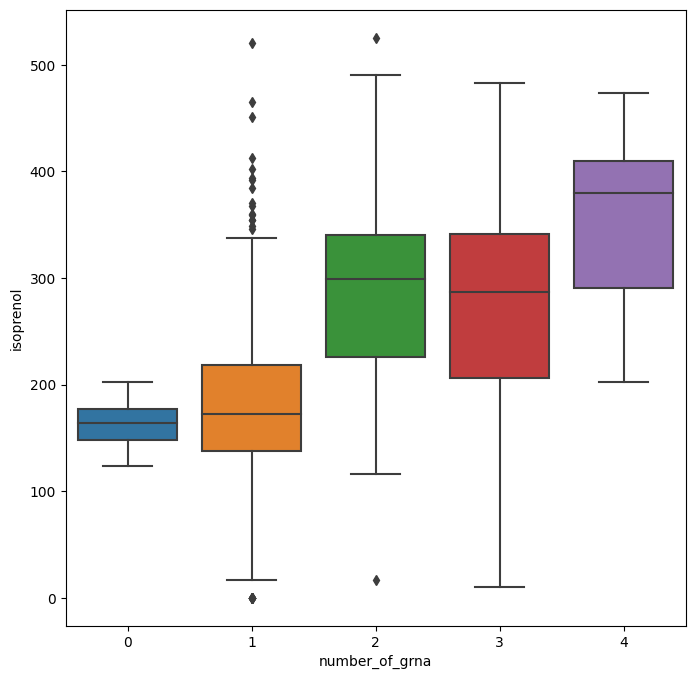

In [71]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df, x = 'number_of_grna', y = 'isoprenol', ax = ax)
fig.savefig(user_params['output_dir'] + 'grna_vs_titer_boxplot.png',  bbox_inches='tight')

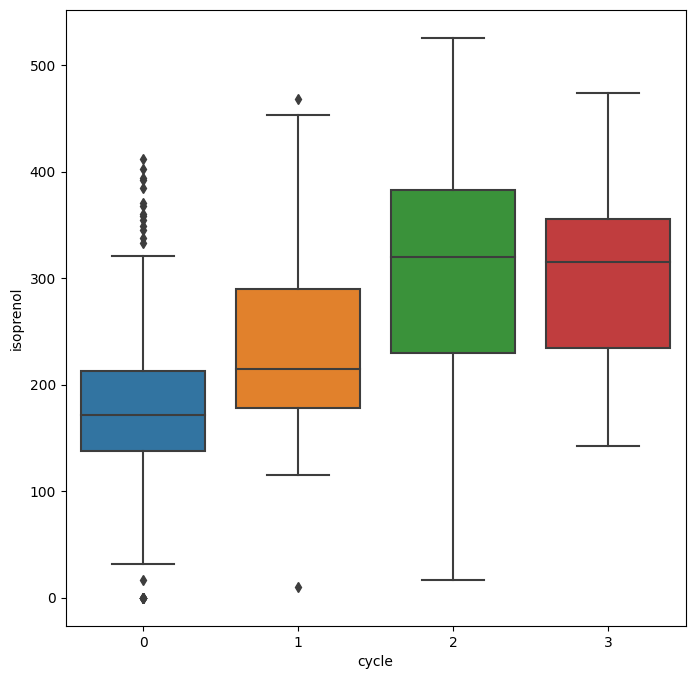

In [72]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df, x = 'cycle', y = 'isoprenol', ax = ax)
fig.savefig(user_params['output_dir'] + 'cycle_vs_titer_boxplot.png',  bbox_inches='tight')

<Axes: xlabel='cycle', ylabel='isoprenol'>

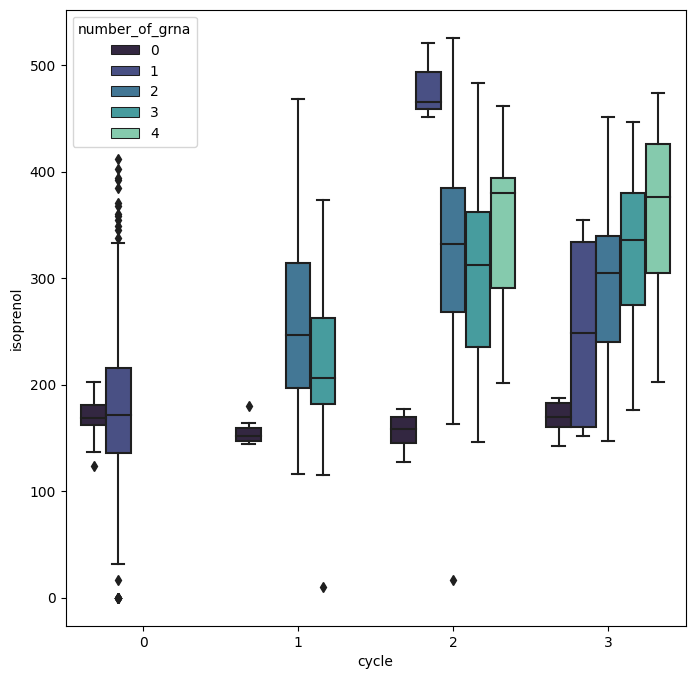

In [73]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df, x = 'cycle', y = 'isoprenol', hue = 'number_of_grna', palette = 'mako', ax = ax)

In [74]:
df.loc[df['cycle'] == 2, ['line_name_norep', 'isoprenol']].groupby('line_name_norep').mean().mean()

isoprenol    317.581674
dtype: float64

In [75]:
df.loc[df['cycle'] == 2, ['line_name_norep', 'isoprenol']].groupby('line_name_norep').mean().sort_values('isoprenol', ascending=False)

,isoprenol
line_name_norep,
PP_0751_PP_0814,480.646767
PP_0815_PP_1317,480.578900
PP_1317,479.387633
PP_0528_PP_0751_PP_0813,476.630833
PP_0528_PP_1769_PP_4191,466.620733
...,...
PP_0368_PP_1769,190.439533
PP_2136_PP_4189,183.626000
PP_0751_PP_4189,178.846767


In [77]:
df.loc[df['cycle'] == 0, 'number_of_grna'].value_counts()/3

number_of_grna
1    129.0
0      6.0
Name: count, dtype: float64

In [78]:
df.loc[df['cycle'] == 1, 'number_of_grna'].value_counts()/3

number_of_grna
3    30.0
2    30.0
0     4.0
Name: count, dtype: float64

In [79]:
df.loc[df['cycle'] == 2, 'number_of_grna'].value_counts()/3

number_of_grna
3    30.0
2    24.0
4     5.0
0     4.0
1     1.0
Name: count, dtype: float64

<Axes: xlabel='number_of_grna', ylabel='isoprenol'>

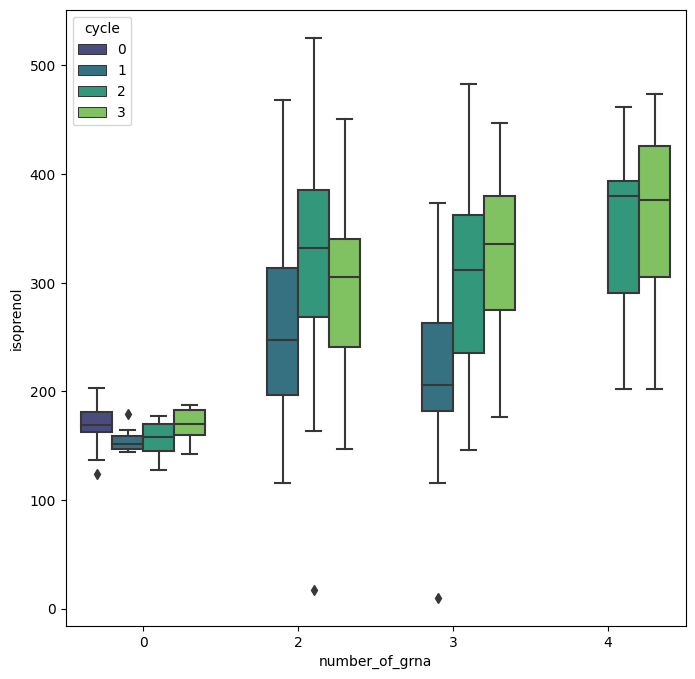

In [80]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df[df['number_of_grna']!=1], hue = 'cycle', y = 'isoprenol', x = 'number_of_grna', palette = 'viridis', ax = ax)

### 3.2 Compare control runs

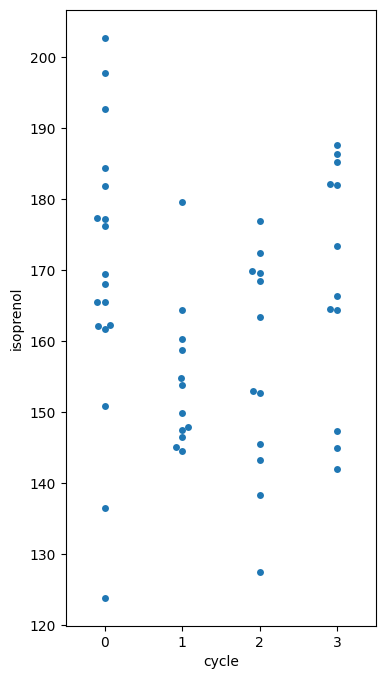

In [81]:
fig, ax = plt.subplots(figsize = (4,8))
sns.swarmplot(data = df[df['is_control']], x = 'cycle', y = 'isoprenol')
fig.savefig(user_params['output_dir'] + 'cycle_control_comparison_swarmplot.png',  bbox_inches='tight')

In [82]:
df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,dbtl1_filter,dbtl3_filter,gRNA_1,gRNA_2,gRNA_3,gRNA_4
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,True,True,None,None,None,None
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,True,True,None,None,None,None
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,True,True,None,None,None,None
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],0,True,True,None,None,None,None
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],0,True,True,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,PP_0815_PP_1317-R3,DBTL3_P4_041,mg/L,380.18410,3,PP_0815_PP_1317,None,3,False,"[PP_0815, PP_1317]",2,NaN,True,PP_0815,PP_1317,None,None
968,PP_0528_PP_0815_PP_1317-R3,DBTL3_P4_042,mg/L,387.53500,3,PP_0528_PP_0815_PP_1317,None,3,False,"[PP_0528, PP_0815, PP_1317]",3,NaN,True,PP_0528,PP_0815,PP_1317,None
969,PP_0812_PP_1769-R3,DBTL3_P4_043,mg/L,364.88230,3,PP_0812_PP_1769,None,3,False,"[PP_0812, PP_1769]",2,NaN,False,PP_0812,PP_1769,None,None
970,PP_4120_PP_4189-R3,DBTL3_P4_044,mg/L,240.66460,3,PP_4120_PP_4189,None,3,False,"[PP_4120, PP_4189]",2,NaN,False,PP_4120,PP_4189,None,None


Can check how similar the two sets of controls are. TODO: Talk about interpretation of this.

In [83]:
from scipy.stats import ttest_ind
ttest_ind(a = df[((df['is_control'] == True) & (df['cycle'] == 0))]['isoprenol'],
          b = df[((df['is_control'] == True) & (df['cycle'] == 1))]['isoprenol'])

TtestResult(statistic=2.463242240240987, pvalue=0.020178632782176124, df=28.0)

In [85]:
from scipy.stats import ttest_ind
comparisons = [[0, 1], [0, 2], [1,2], [0,3], [1,3], [2,3]]
for c in comparisons:
    a = df[((df['is_control'] == True) & (df['cycle'] == c[0]))]['isoprenol']
    b = df[((df['is_control'] == True) & (df['cycle'] == c[1]))]['isoprenol']
    s, p = ttest_ind(a = a, b = b)
    print(f"Comparison between cycle {c[0]} and cycle {c[1]}: s = {s:.3f}, p = {p:.3f}")

Comparison between cycle 0 and cycle 1: s = 2.463, p = 0.020
Comparison between cycle 0 and cycle 2: s = 1.908, p = 0.067
Comparison between cycle 1 and cycle 2: s = -0.431, p = 0.670
Comparison between cycle 0 and cycle 3: s = 0.134, p = 0.894
Comparison between cycle 1 and cycle 3: s = -2.546, p = 0.018
Comparison between cycle 2 and cycle 3: s = -1.824, p = 0.082


### 3.3 Plot all strains

In [86]:
df['line_name_norep_cycle'] = df.apply(lambda x: f"{x['line_name_norep']}_c{x['cycle']}", axis = 1)

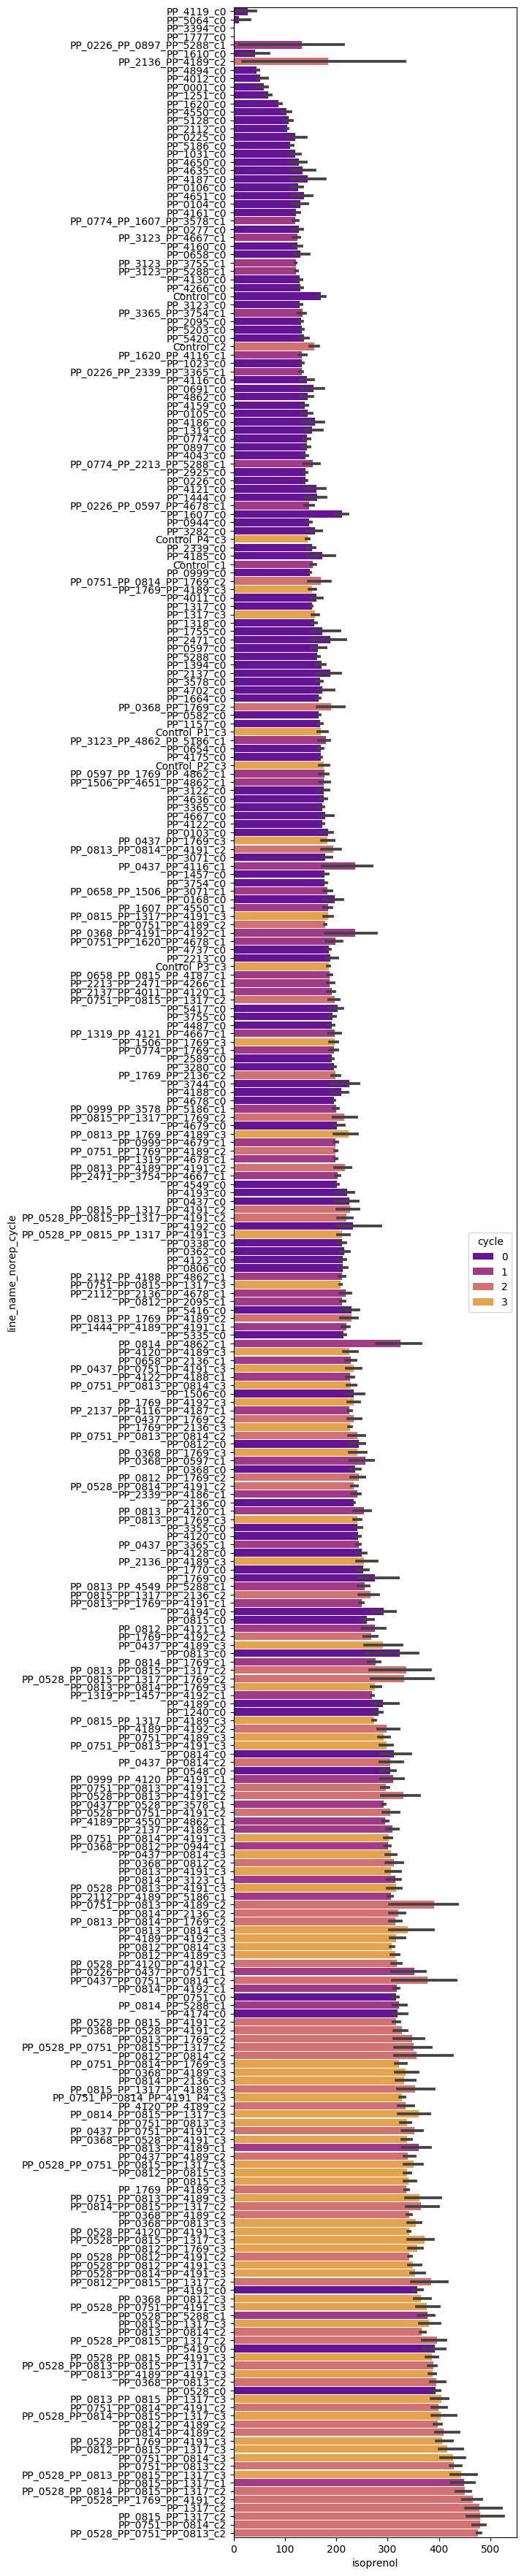

In [87]:
fig, ax = plt.subplots(figsize = (5,45))
sns.barplot(data = df.sort_values('isoprenol', ascending=True), y = 'line_name_norep_cycle', x = 'isoprenol', hue = 'cycle', ax = ax, dodge = False, width = 0.9, palette = 'plasma')
fig.savefig(user_params['output_dir'] + 'mean_bargraph_by_strain.png',  bbox_inches='tight')

### Identify repeat strains

In [56]:
len(df.loc[df['line_name_norep'] == 'PP_1317', 'cycle'].unique())


2

In [88]:
def count_unique_cycles(x, df):
    return len(df.loc[df['line_name_norep'] == x, 'cycle'].unique())

df['n_unique_cycles'] = df['line_name_norep'].apply(lambda x: count_unique_cycles(x, df))
df.head(3)

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,dbtl1_filter,dbtl3_filter,gRNA_1,gRNA_2,gRNA_3,gRNA_4,line_name_norep_cycle,n_unique_cycles
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3


Plot strains that have replicates between cycles.

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/categorical.py:354

<Axes: xlabel='isoprenol', ylabel='line_name_norep'>

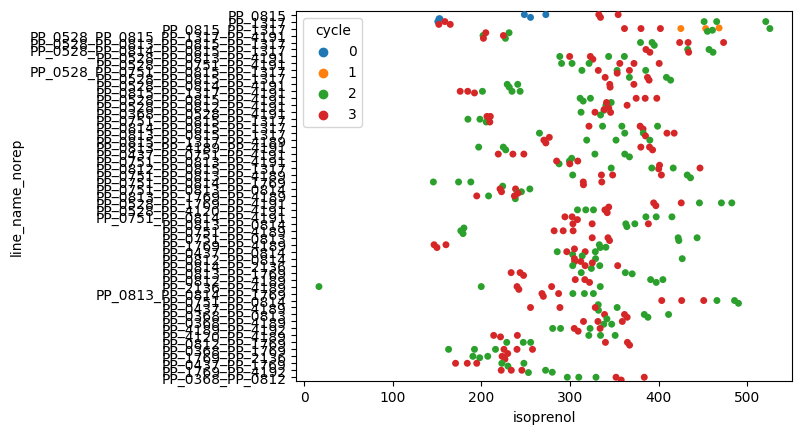

In [92]:
df[df['n_unique_cycles']>1]
sns.swarmplot(df[(df['n_unique_cycles']>1) & (df['is_control'] == False)], y = 'line_name_norep', x = 'isoprenol', hue = 'cycle', palette = 'tab10', orient='h')

### Look for differences in control strains

In [93]:
df[df['is_control']]

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,dbtl1_filter,dbtl3_filter,gRNA_1,gRNA_2,gRNA_3,gRNA_4,line_name_norep_cycle,n_unique_cycles
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
5,Control-R6,BL2C1_NT,mg/L,162.31847,6,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
6,Control-R7,BL3A1_NT,mg/L,162.12527,7,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
7,Control-R8,BL3B1_NT,mg/L,165.52560,8,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
8,Control-R9,BL3C1_NT,mg/L,165.55333,9,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3
9,Control-R10,BL4A1_NT,mg/L,176.13507,10,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3


In [94]:
df.loc[(df['is_control']) & (df['cycle']>0), 'control_plate'] = df.loc[df['is_control'],'Line Name'].apply(lambda x: int(x[9])).astype(int)

In [95]:
df[df['is_control']]

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,dbtl1_filter,dbtl3_filter,gRNA_1,gRNA_2,gRNA_3,gRNA_4,line_name_norep_cycle,n_unique_cycles,control_plate
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
5,Control-R6,BL2C1_NT,mg/L,162.31847,6,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
6,Control-R7,BL3A1_NT,mg/L,162.12527,7,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
7,Control-R8,BL3B1_NT,mg/L,165.52560,8,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
8,Control-R9,BL3C1_NT,mg/L,165.55333,9,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN
9,Control-R10,BL4A1_NT,mg/L,176.13507,10,Control,None,0,True,[],0,True,True,None,None,None,None,Control_c0,3,NaN


<Axes: xlabel='cycle', ylabel='isoprenol'>

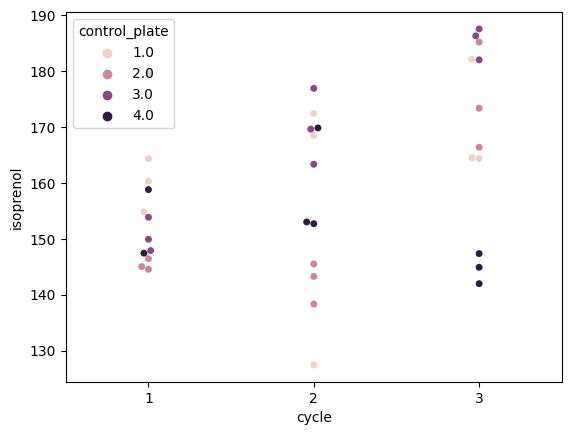

In [96]:
sns.swarmplot(data = df.loc[(df['is_control']) & (df['cycle'] >0 ),:],   x = 'cycle', y = 'isoprenol', hue = 'control_plate')

In [98]:
control_df = df.loc[(df['is_control']) & (df['cycle'] >-1 ),:].copy()
cycle0_plate_list = pd.read_excel('./DBTL0_data/sample injection order.xlsx')
plate_dict = dict(zip(cycle0_plate_list['Sample Name in order injected'], cycle0_plate_list['Batch number']))
control_df.loc[control_df['cycle']==0,'control_plate'] = control_df.loc[control_df['cycle']==0,'Line Name'].apply(lambda x: plate_dict[x])
control_df['control_plate'] = control_df['control_plate'].astype(int)

<Axes: xlabel='isoprenol', ylabel='plate_cycle'>

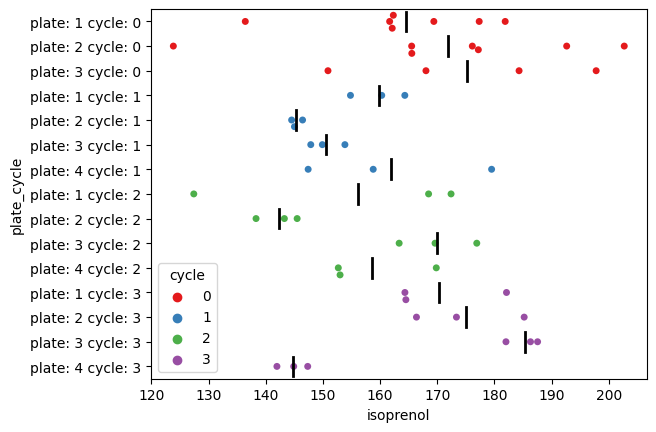

In [99]:
control_df['plate_cycle'] = control_df.apply(lambda x: f"plate: {int(x['control_plate'])} cycle: {x['cycle']}", axis = 1)
control_df
p=sns.swarmplot(data = control_df,   y = 'plate_cycle', x = 'isoprenol', hue = 'cycle', palette = 'Set1')

# p = sns.stripplot(x="method", y="distance", data=planets, size=4, color=".7")
# plt.xticks(rotation=45, ha="right")
# p.set(yscale='log')

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="isoprenol",
            y="plate_cycle",
            data=control_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)

In [102]:
pctcv_df = pd.DataFrame(columns = ['cycle','plate', 'mean', 'std', 'pctcv'])
pctcv_df['cycle'] = [0,0,0,1,1,1,1,2,2,2,2, 3,3,3,3]
pctcv_df['plate'] = [1,2,3,1,2,3,4,1,2,3,4, 1,2,3,4]
for idx, srs in pctcv_df.iterrows():
    pctcv_df.loc[idx, 'mean'] = control_df.loc[(control_df['is_control']) & (control_df['cycle'] == srs['cycle']) & (control_df['control_plate']==srs['plate']), 'isoprenol'].mean()
    pctcv_df.loc[idx, 'std'] = control_df.loc[(control_df['is_control']) & (control_df['cycle'] == srs['cycle']) & (control_df['control_plate']==srs['plate']), 'isoprenol'].std()
    
pctcv_df['pctcv'] =100* pctcv_df['std']/pctcv_df['mean']

<Axes: xlabel='cycle', ylabel='pctcv'>

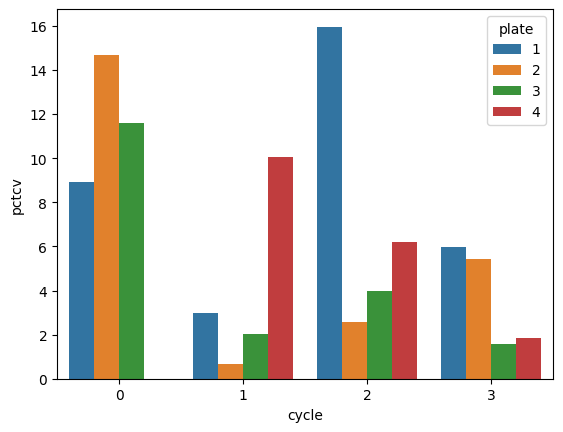

In [103]:
pctcv_df
sns.barplot(data = pctcv_df, x = 'cycle', hue = 'plate', y = 'pctcv')